<a href="https://colab.research.google.com/github/yuktapanchal19/Speech_Emotion_Recognition/blob/main/speech_emotion_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install streamlit pyngrok librosa soundfile scikit-learn xgboost --quiet

In [21]:
!ngrok config add-authtoken 2zXkpL2MEGRfTRm9P494EE8lgbe_6pqofhDqAbHnRzgeBG7ch

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ X_train_pca shape: (614, 64)
✅ y_train_encoded shape: (614,)

✅ Model Accuracy: 70.13%

📊 Classification Report:
              precision    recall  f1-score   support

        calm       0.86      0.84      0.85        43
     disgust       0.59      0.81      0.68        37
     fearful       0.75      0.65      0.70        37
       happy       0.62      0.49      0.55        37

    accuracy                           0.70       154
   macro avg       0.70      0.70      0.69       154
weighted avg       0.71      0.70      0.70       154



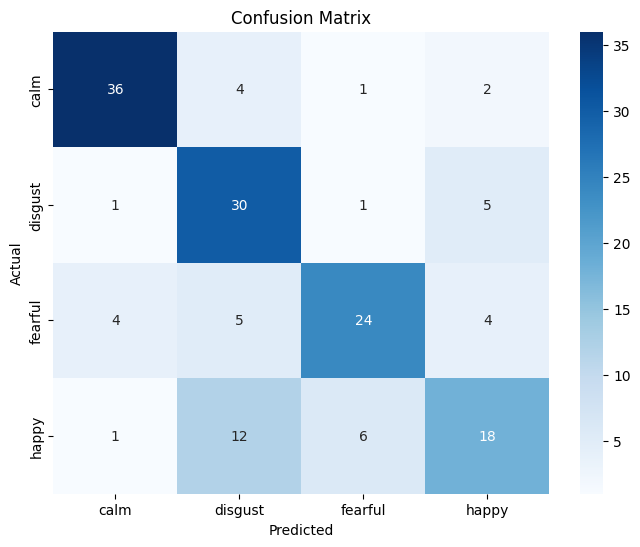

['pca.pkl']

In [29]:
from google.colab import drive
drive.mount('/content/drive')

!pip install streamlit pyngrok librosa soundfile scikit-learn xgboost seaborn --quiet

import os
import glob
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Emotions in the RAVDESS dataset
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

observed_emotions = ['02', '03', '06', '07']  # calm, happy, fearful, disgust

def extract_feature(file_name, mfcc=True, chroma=True, mel=True, spectral_contrast=True, tonnetz=True):
    with sf.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        result = np.array([])

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=60).T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            stft = np.abs(librosa.stft(X))
            chroma_feature = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_feature))

        if mel:
            mel_feature = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_feature))

        if spectral_contrast:
            spectral_contrast_feature = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, spectral_contrast_feature))

        if tonnetz:
            tonnetz_feature = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz_feature))

    return result

def load_data(test_size=0.2):
    x, y = [], []
    for file in glob.glob("/content/drive/MyDrive/Ravdess data/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion_code = file_name.split("-")[2]
        if emotion_code not in observed_emotions:
            continue
        features = extract_feature(file)
        x.append(features)
        y.append(emotions[emotion_code])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)


X_train, X_test, y_train, y_test = load_data()

# Encode labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("X_train_pca shape:", X_train_pca.shape)
print("y_train_encoded shape:", y_train_encoded.shape)

model = XGBClassifier()
model.fit(X_train_pca, y_train_encoded)

y_pred = model.predict(X_test_pca)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test_encoded, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

joblib.dump(model, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

with open("model_accuracy.txt", "w") as f:
    f.write(f"{accuracy:.2%}")

joblib.dump(model, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")


In [22]:
import joblib

joblib.dump(model, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")


['pca.pkl']

In [23]:
%%writefile streamlit_app.py
import streamlit as st
import numpy as np
import librosa
import soundfile as sf
import joblib

model = joblib.load("xgb_model.pkl")
scaler = joblib.load("scaler.pkl")
pca = joblib.load("pca.pkl")

def extract_audio_features(file_path):
    with sf.SoundFile(file_path) as sound_file:
        signal = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        features = np.array([])

        # MFCC
        mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=60).T, axis=0)
        features = np.hstack((features, mfcc))

        # Chroma
        stft = np.abs(librosa.stft(signal))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        features = np.hstack((features, chroma))

        # Mel
        mel = np.mean(librosa.feature.melspectrogram(y=signal, sr=sample_rate).T, axis=0)
        features = np.hstack((features, mel))

        # Spectral Contrast
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
        features = np.hstack((features, contrast))

        # Tonnetz
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(signal), sr=sample_rate).T, axis=0)
        features = np.hstack((features, tonnetz))

    return features.reshape(1, -1)

st.title(" Speech Emotion Recognition App")
st.write("Upload a `.wav` file and detect the speaker's emotion.")

uploaded_file = st.file_uploader("Choose a .wav audio file", type=["wav"])

if uploaded_file is not None:
    st.audio(uploaded_file, format="audio/wav")

    with open("temp.wav", "wb") as f:
        f.write(uploaded_file.read())

    features = extract_audio_features("temp.wav")
    scaled = scaler.transform(features)
    reduced = pca.transform(scaled)

    prediction = model.predict(reduced)[0]
    st.success(f"Predicted Emotion: **{prediction.upper()}**")


Overwriting streamlit_app.py


In [24]:
from pyngrok import ngrok
import time

!pkill streamlit

get_ipython().system_raw("streamlit run streamlit_app.py &")

time.sleep(5)

public_url = ngrok.connect("http://localhost:8501")
print(" Your Streamlit app is live at:", public_url)


🚀 Your Streamlit app is live at: NgrokTunnel: "https://0ec7-35-247-30-176.ngrok-free.app" -> "http://localhost:8501"
